### Wczytanie pakietów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import dalex as dx
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
warnings.filterwarnings(action='ignore')

In [13]:
X_train = pd.read_csv('Xtrain.csv')
X_test = pd.read_csv('Xtest.csv')
y_train = pd.read_csv('ytrain.csv')

In [14]:
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_test = X_test.drop(['Unnamed: 0'], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)

### Informacje o zbiorach

In [15]:
cols = X_train.columns
print(f'X_train\nNumber of rows: {X_train.shape[0]}.\nNumber of cols: {X_train.shape[1]}\n')
print(f'X_test\nNumber of rows: {X_test.shape[0]}.\nNumber of cols: {X_test.shape[1]}\n')
print(f'y_train\nNumber of rows: {y_train.shape[0]}.')

X_train
Number of rows: 192000.
Number of cols: 100

X_test
Number of rows: 48000.
Number of cols: 100

y_train
Number of rows: 192000.


Text(0.5, 1.0, 'Visualization of NaNs')

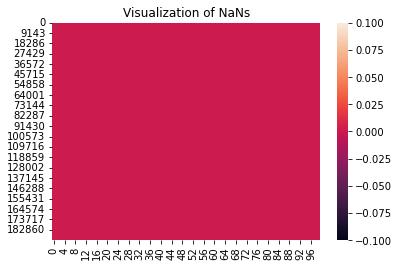

In [16]:
sns.heatmap(X_train.isna())
plt.title('Visualization of NaNs')

In [17]:
max(X_train.isna().sum()) # nie ma brakow danych 

0

### Korelacja

In [18]:
# kod skopiowany z https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=15):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [19]:
get_top_abs_correlations(X_train, 20)

19  21    0.867156
17  22    0.860141
15  22    0.848244
    17    0.809042
    19    0.730560
21  22    0.718146
17  21    0.718059
19  22    0.711910
15  21    0.704048
17  19    0.693433
57  59    0.671656
5   17    0.648966
20  23    0.639938
18  23    0.633619
5   22    0.622700
18  20    0.612639
16  18    0.586460
7   59    0.579583
14  18    0.574752
5   21    0.574094
dtype: float64

potencjalnie mozemy usunac zmienna 21, 22 i zobaczyc co dalej

In [20]:
columns_to_drop = ['21', '15', '22']
X_train = X_train.drop(columns=columns_to_drop)

In [32]:
cols = X_train.columns

In [26]:
X_test = X_test.drop(columns=columns_to_drop)

In [21]:
get_top_abs_correlations(X_train, 20)

17  19    0.693433
57  59    0.671656
5   17    0.648966
20  23    0.639938
18  23    0.633619
    20    0.612639
16  18    0.586460
7   59    0.579583
14  18    0.574752
0   1     0.563400
16  20    0.563342
17  29    0.550783
14  16    0.540999
17  34    0.519070
3   17    0.518396
0   62    0.516965
13  14    0.511409
45  62    0.511009
60  78    0.509056
7   64    0.498254
dtype: float64

### Wykresy

Text(0.5, 1.0, 'Histogram of y_train values in log scale')

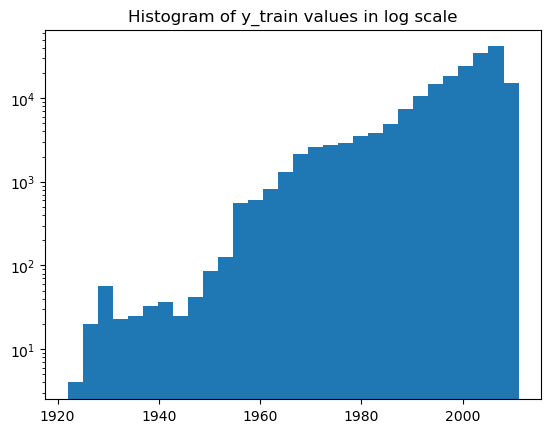

In [166]:
plt.hist(y_train['0'], bins=30, log=True)
plt.title('Histogram of y_train values in log scale')

In [167]:
y_lim_up = 1e4
y_lim_dw = -5e3

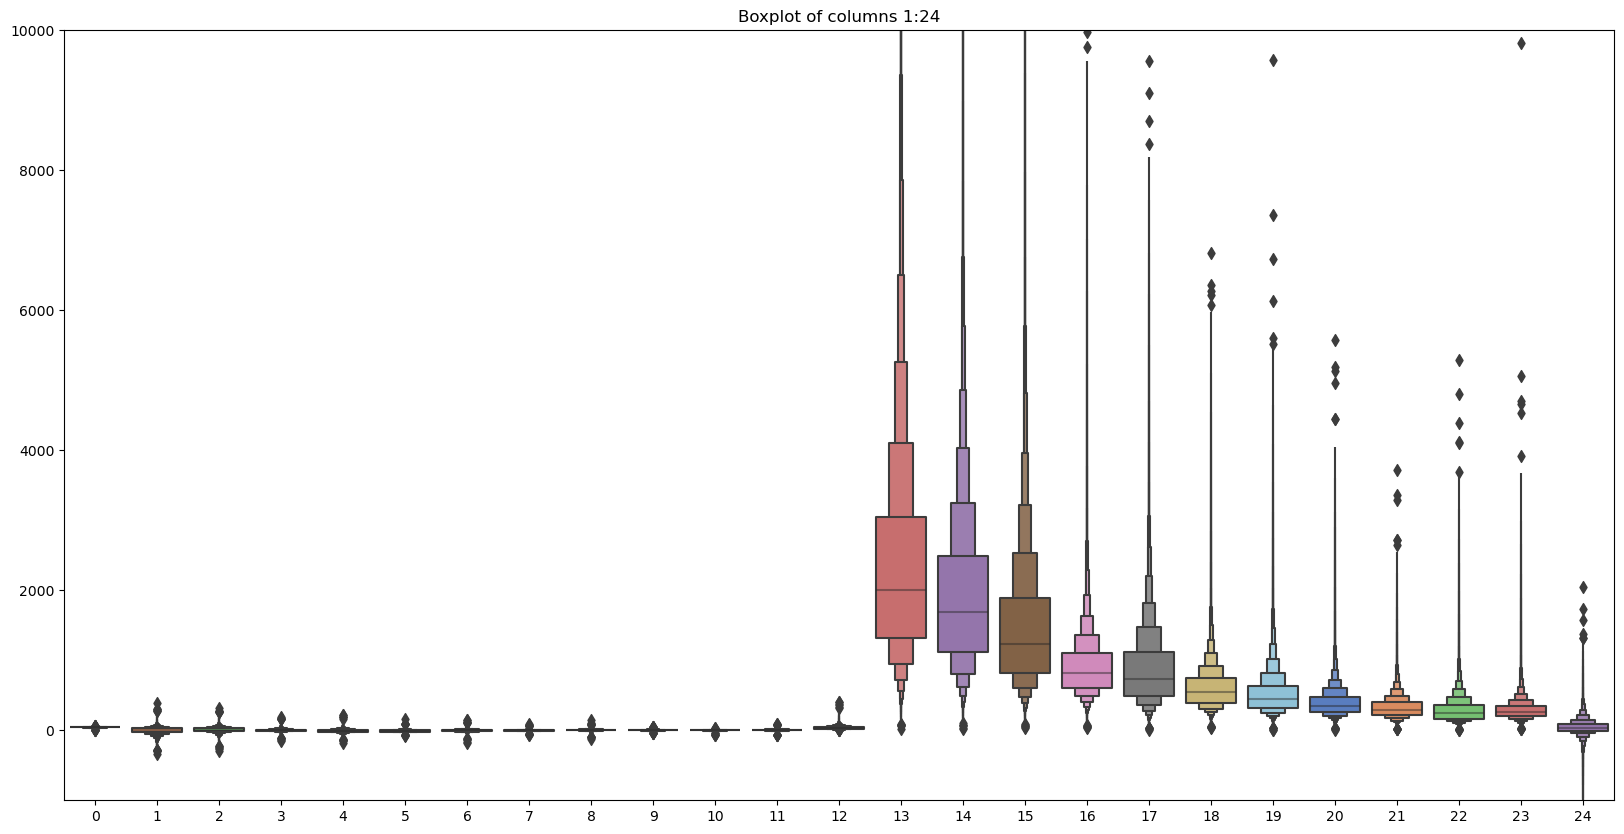

In [168]:
plt.figure(figsize=(20, 10))
sns.boxenplot(X_train.iloc[:, :25],palette='muted', scale='exponential')
plt.title('Boxplot of columns 1:24')
plt.ylim(y_lim_dw, y_lim_up)
plt.show()

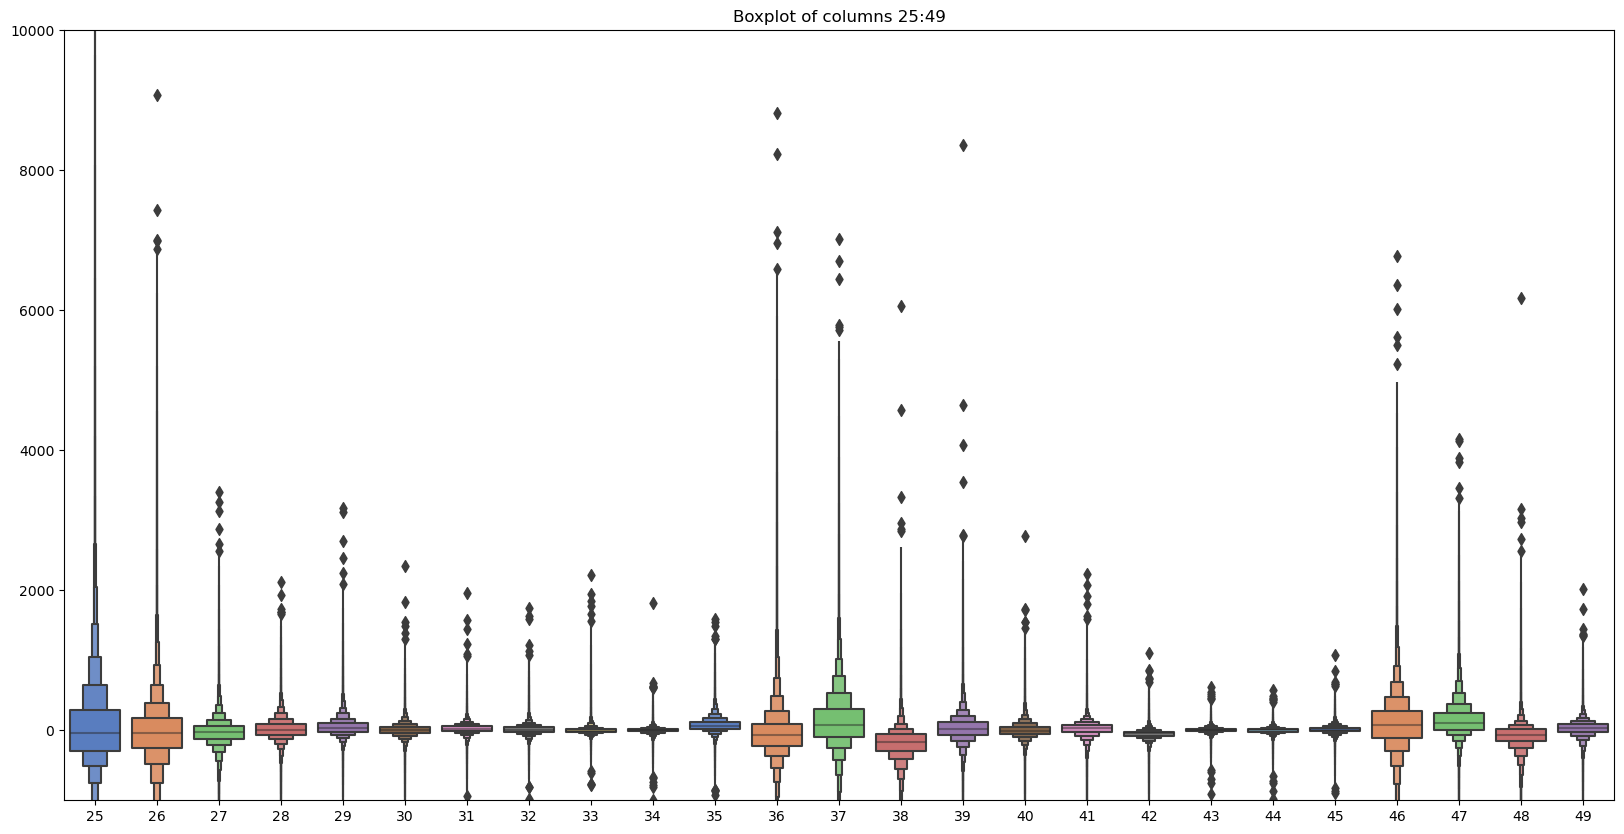

In [169]:
plt.figure(figsize=(20, 10))
sns.boxenplot(X_train.iloc[:, 25:50],palette='muted', scale='exponential')
plt.title('Boxplot of columns 25:49')
plt.ylim(y_lim_dw, y_lim_up)
plt.show()

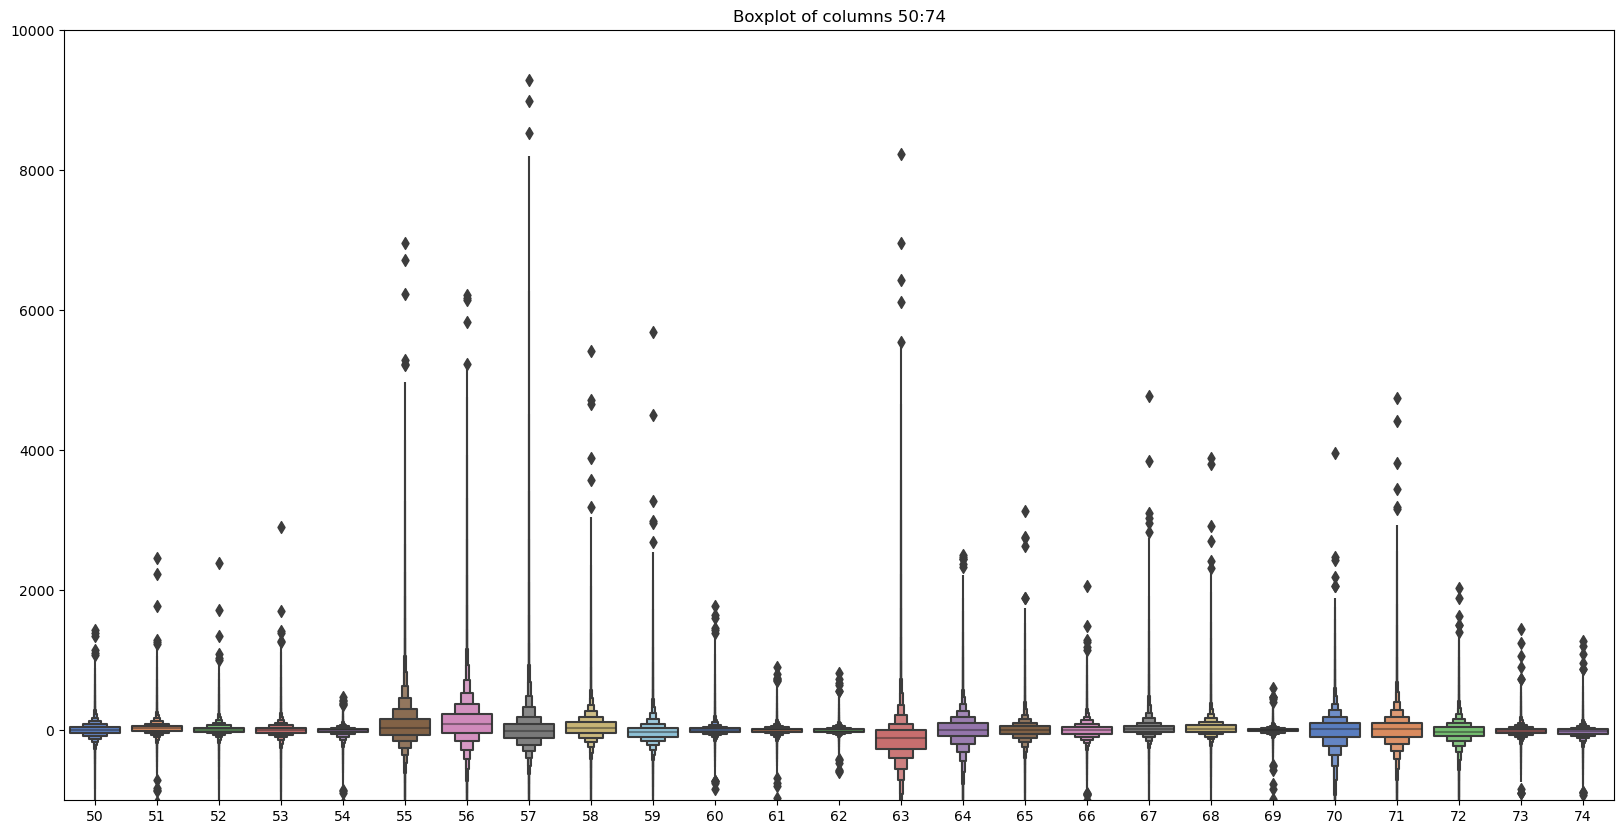

In [170]:
plt.figure(figsize=(20, 10))
sns.boxenplot(X_train.iloc[:, 50:75],palette='muted', scale='exponential')
plt.title('Boxplot of columns 50:74')
plt.ylim(y_lim_dw, y_lim_up)
plt.show()

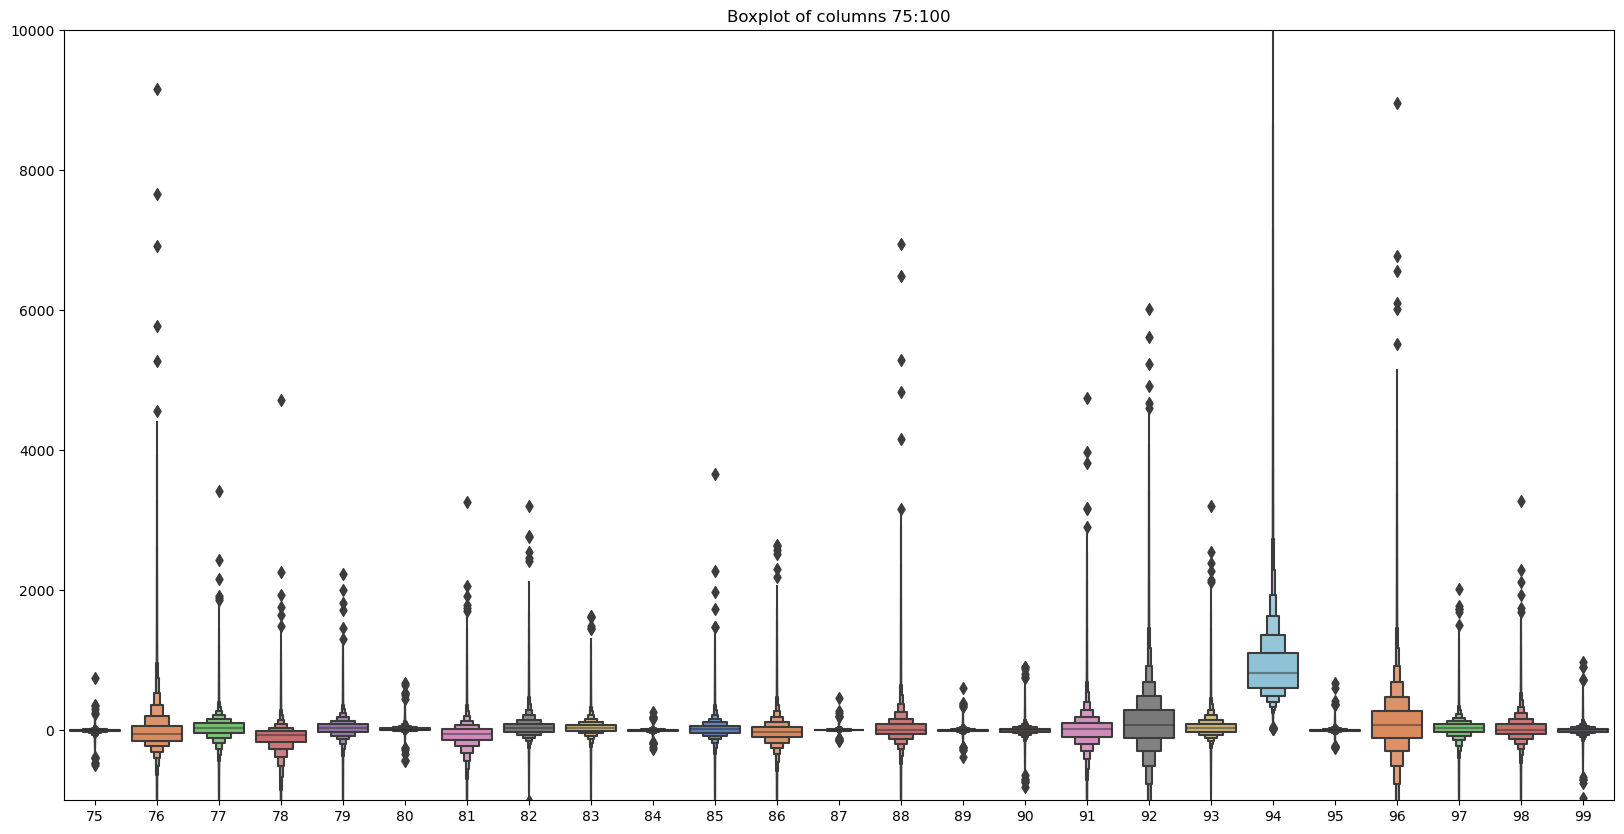

In [171]:
plt.figure(figsize=(20, 10))
sns.boxenplot(X_train.iloc[:, 75:100],palette='muted', scale='exponential')
plt.title('Boxplot of columns 75:100')
plt.ylim(y_lim_dw, y_lim_up)
plt.show()

### Korelacja

In [ ]:
# kod skopiowany z https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=15):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [ ]:
get_top_abs_correlations(X_train, 20)

In [ ]:
columns_to_drop = ['21', '15']
X_train = X_train.drop(columns=columns_to_drop)

In [ ]:
get_top_abs_correlations(X_train, 20)

### Preprocesing danych

In [33]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

numTransformer = ColumnTransformer([
    ('numerical', numerical_transformer, X_train.columns),
])

In [34]:
X_train = pd.DataFrame(numTransformer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(numTransformer.transform(X_test), columns=cols)

Text(0.5, 1.0, 'Correlation between variables after scaling')

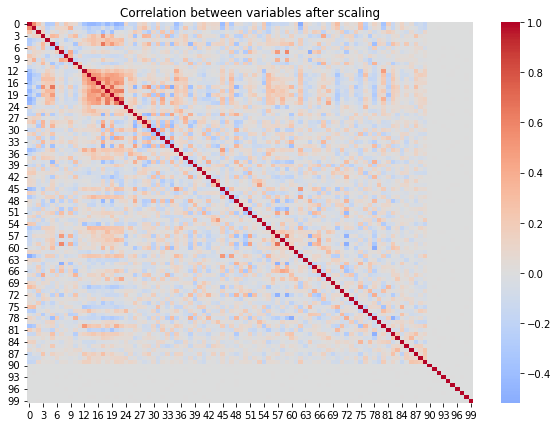

In [35]:
plt.figure(figsize=(10,7))
sns.heatmap(X_train.corr(), cmap='coolwarm', center=0)
plt.title('Correlation between variables after scaling')

<h2>Importance of Variables</h2>

In [54]:
X_train_v2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
174695,0.243923,1.666746,-1.905439,2.045813,0.816544,-0.794710,0.061809,2.858323,-1.376922,1.076624,...,0.191324,0.170197,-0.382899,-0.669101,1.885828,0.159753,-0.663767,1.026465,0.216259,1.144454
127389,0.213147,0.060293,1.018798,0.602011,0.245832,-0.885867,-0.006210,-0.570027,-0.593007,-0.011339,...,-0.418108,-0.681220,-1.154343,-0.369725,-0.150598,1.891640,-1.339620,-0.711791,-0.642829,0.317128
30654,0.165614,0.255568,1.298935,0.351757,0.172540,0.799391,-0.727232,-0.200948,-0.014425,-0.304648,...,-0.317235,-0.457569,-0.171020,-0.609914,0.696510,-1.859481,-0.302224,0.415735,0.321924,0.685659
189099,1.090490,0.411574,-0.303701,-1.151554,0.849279,-0.329810,-0.114423,-0.545182,0.353151,-0.273598,...,-0.235410,0.720187,-0.384374,-0.603887,2.783989,0.266406,1.474172,0.387620,-0.454126,-0.581360
43131,0.066095,-0.409501,-0.806863,0.266856,-0.846345,0.996578,-0.523980,-2.197107,0.488547,-1.811819,...,1.273607,-0.407155,-0.179519,-0.382689,1.439614,-0.775036,0.436479,-0.066830,0.149945,-0.999431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30489,-2.128359,-1.771691,1.694970,1.050927,1.364607,-0.341205,-0.019356,0.873361,0.571789,0.471617,...,0.930403,0.034712,-0.724681,-0.847077,-0.841183,0.018962,0.462969,-0.333356,-0.210873,0.970341
125987,1.278675,1.004694,0.231996,1.116381,0.098436,-0.959447,0.903143,1.755934,-0.626296,1.376799,...,-0.253538,0.275186,-0.216845,0.742050,-0.237085,-0.420894,0.140219,-2.332545,0.926379,-0.475194
59719,-0.549801,-0.258163,-0.206138,0.925378,0.441316,1.877662,-0.260851,0.178811,0.062147,0.653933,...,1.381162,0.394807,-0.796962,-0.404532,-0.844792,-0.630680,0.655461,-0.035199,-1.564994,1.129032
135387,-2.976032,1.274088,0.374022,-1.631420,1.854544,3.634297,-2.929252,1.255249,-3.450813,0.484946,...,0.301114,0.145463,0.578861,-0.089189,-0.440642,-0.018312,0.087126,0.364069,0.302374,-1.632178


In [38]:
X_train_v2 , X_train_val, y_train_v2, y_train_val = train_test_split(X_train, y_train, test_size=0.1)

<h3>Random Forrest</h3>

In [39]:
model = RandomForestRegressor()
model.fit(X_train_val, y_train_val)

importances = model.feature_importances_

importance_df = pd.DataFrame({'Feature': cols, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

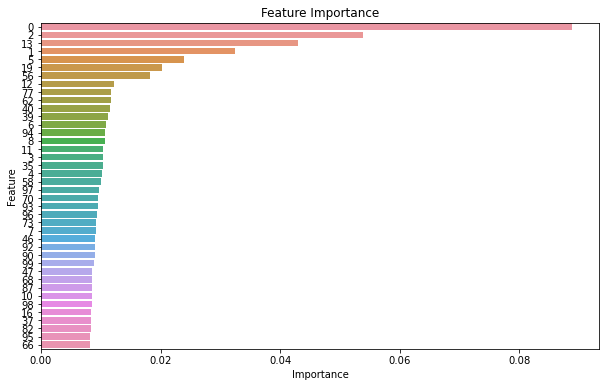

In [40]:
plt.figure(figsize=(10, 6));
sns.barplot(x='Importance', y='Feature', data=importance_df.iloc[:40,])
plt.title('Feature Importance')
plt.show()

<h3>Lasso</h3>

In [11]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_val, y_train_val)

lasso_importances = np.abs(lasso.coef_)
lasso_importance_df = pd.DataFrame({'Feature': cols, 'Importance': lasso_importances})
lasso_importance_df = lasso_importance_df.sort_values(by='Importance', ascending=False)

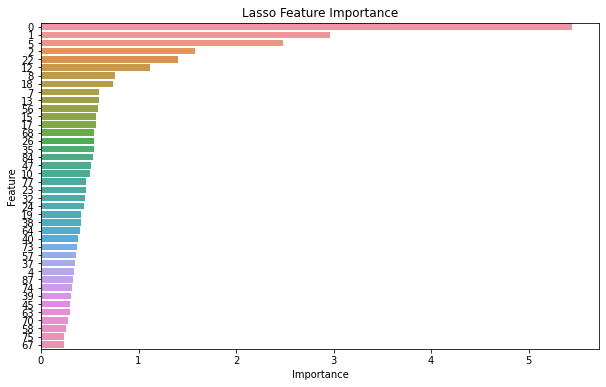

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lasso_importance_df.iloc[:40,])
plt.title('Lasso Feature Importance')
plt.show()

In [44]:
columns_to_learn_RF = list(importance_df.iloc[:20,].index)
#columns_to_learn_Lasso = list(lasso_importance_df.iloc[:30,].index)

In [246]:
#columns_to_learn_RF

[0, 2, 13, 1, 5, 40, 39, 56, 6, 19, 77, 35, 16, 8, 12, 58, 72, 4, 91, 62]

In [247]:
#columns_to_learn_Lasso

[0, 1, 5, 2, 22, 12, 26, 17, 8, 10, 7, 19, 77, 15, 13, 56, 18, 47, 35, 14]

In [248]:
#X_train_v2.iloc[:,columns_to_learn_RF]

,0,2,13,1,5,40,39,56,6,19,77,35,16,8,12,58,72,4,91,62
72146,-2.493068,1.837517,-0.640283,-3.190094,0.098214,-0.453458,0.854416,-1.306606,2.096040,-0.903410,0.965569,0.354656,-0.306156,-3.242382,-1.002782,-0.973777,0.453340,1.158646,1.166243,1.230877
16457,-0.194279,-0.769755,0.133277,0.115009,-0.296542,0.026917,-0.292679,-0.310297,-0.647649,-0.176978,-0.708128,0.191644,0.130836,0.274017,-0.033868,0.334134,0.055201,0.552280,1.153009,1.102338
72946,-2.418421,0.866629,0.553109,-1.765269,-0.211993,-0.661012,-2.175259,1.272430,1.134846,0.286954,-2.530898,2.556079,1.351176,-1.024955,0.359817,-1.407344,-1.111983,0.638067,-0.753754,1.741291
46758,-0.384179,-1.583301,-0.070089,-1.053012,0.636859,0.596509,-1.180178,0.409692,-0.530553,-0.617516,-0.226644,-0.580240,-0.603745,1.788567,-0.976809,-0.249049,-0.145559,-0.877435,1.403569,0.612140
116441,1.190008,0.421920,-1.244906,1.364810,-2.087415,-0.075892,-0.505315,0.123550,1.005966,-1.325040,-0.150226,-0.609739,-1.383466,0.385550,-1.473302,-0.274541,0.221363,0.417351,0.463923,-0.127866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136998,0.444576,2.228676,0.304788,-1.482238,-0.034682,-0.206633,0.668684,-0.971366,-2.244436,-0.992594,0.982469,-1.622781,0.386426,1.299002,-0.091197,-1.990338,0.546400,-1.475827,-0.089411,-0.273097
96391,1.597154,0.439667,-0.842341,1.141628,-1.099169,-0.640479,-0.199676,0.547890,0.193751,-0.519110,-0.688765,-0.111133,-1.181052,0.603708,-1.039259,-0.561423,0.123367,-0.299870,-0.238711,-0.210196
42901,1.184351,-0.299032,-0.437191,0.654008,-1.573517,-0.034336,0.074742,-0.210778,0.904203,-0.756418,0.109269,0.306990,-0.825993,0.431407,0.483191,-0.749635,0.115756,-0.987670,0.232086,0.118855
36812,0.297855,-0.621395,-0.662720,0.383252,0.039173,0.282853,0.303267,-0.864159,-1.256542,-0.609627,-0.181183,-1.114017,0.018222,-0.958878,-0.421610,-0.214974,1.265311,-1.116327,-0.735913,0.089917


### Teraz zbadamy czy dla mniejszego podziobu cech osiagamy lepsza predykcja, LR vs LASS

In [17]:
X_train_v3, X_test_v3, y_train_opt, y_test_opt = train_test_split(X_train_v2, y_train_v2, test_size=0.2)

In [21]:
# Las dla optymalnych
forest = RandomForestRegressor()
X_train_opt = X_train_v3.iloc[:,columns_to_learn_RF]
X_test_opt = X_test_v3.iloc[:,columns_to_learn_RF]
forest.fit(X_train_opt, y_train_opt)
y_pred = forest.predict(X_test_opt)
mse = mean_squared_error(y_test_opt, y_pred)
print(mse)

86.85881560185184


In [22]:
# Las dla pelnych
forest_full = RandomForestRegressor()
forest_full.fit(X_train_v3, y_train_opt)
y_pred_full = forest_full.predict(X_test_v3)
mse = mean_squared_error(y_test_opt, y_pred_full)
print(mse)

KeyboardInterrupt: 

In [24]:
from sklearn.linear_model import LinearRegression

In [38]:
# Regresja dla optymalnych
regresja = LinearRegression()
X_train_opt = X_train_v3.iloc[:,columns_to_learn_Lasso]
X_test_opt = X_test_v3.iloc[:,columns_to_learn_Lasso]
regresja.fit(X_train_opt, y_train_opt)
y_pred = regresja.predict(X_test_opt)
mse = mean_squared_error(y_test_opt, y_pred)
print(mse)

91.70110912737648


In [31]:
# Regresja dla pelnych
regresja_full = LinearRegression()
regresja_full.fit(X_train_v3, y_train_opt)
y_pred_full = regresja_full.predict(X_test_v3)
mse = mean_squared_error(y_test_opt, y_pred_full)
print(mse)

90.45543417962865


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
regresja = GradientBoostingRegressor()
X_train_opt = X_train_v3.iloc[:,columns_to_learn_Lasso]
X_test_opt = X_test_v3.iloc[:,columns_to_learn_Lasso]
regresja.fit(X_train_opt, y_train_opt)
y_pred = regresja.predict(X_test_opt)
mse = mean_squared_error(y_test_opt, y_pred)
print(mse)

87.66366656024947


In [39]:
regresja = GradientBoostingRegressor()
regresja.fit(X_train_v3, y_train_opt)
y_pred = regresja.predict(X_test_v3)
mse = mean_squared_error(y_test_opt, y_pred)
print(mse)

KeyboardInterrupt: 

In [ ]:
#X_train_v2.iloc[:,columns_to_learn_RF]

In [49]:
importance_df.iloc[:20,].index

Index([0, 2, 13, 1, 5, 18, 53, 12, 74, 59, 37, 36, 6, 91, 8, 11, 3, 32, 4, 55], dtype='int64')

In [51]:
X_train_v2.iloc[:,importance_df.iloc[:20,].index].columns

Index(['0', '2', '13', '1', '5', '19', '56', '12', '77', '62', '40', '39', '6',
       '94', '8', '11', '3', '35', '4', '58'],
      dtype='object')

In [68]:
X_train_v2.insna().sum()

AttributeError: 'DataFrame' object has no attribute 'insna'

In [73]:
cv_split

KFold(n_splits=6, random_state=123, shuffle=True)

In [75]:
X_train_v2.shape[0]

172800

In [81]:
X_train_v2[current_features_knn]

,97,70,93,96,73,7,46,92,90,99,47,68,87,10,98,16
174695,1.026465,1.173878,-0.669101,-0.663767,1.383252,2.858323,0.813699,-0.382899,0.191324,1.144454,1.936301,-0.136628,0.564053,1.157322,0.216259,1.348920
127389,-0.711791,0.367843,-0.369725,-1.339620,-0.146005,-0.570027,-0.141760,-1.154343,-0.418108,0.317128,-0.413463,0.718028,0.378333,1.903229,-0.642829,-0.962276
30654,0.415735,-0.025663,-0.609914,-0.302224,-0.126320,-0.200948,0.182174,-0.171020,-0.317235,0.685659,0.740246,1.240000,-1.634307,-0.221698,0.321924,0.285983
189099,0.387620,0.080413,-0.603887,1.474172,0.087159,-0.545182,0.275654,-0.384374,-0.235410,-0.581360,-0.361524,-0.265680,0.663531,-1.049247,-0.454126,-0.317071
43131,-0.066830,-0.471975,-0.382689,0.436479,0.090652,-2.197107,-0.493234,-0.179519,1.273607,-0.999431,0.011241,-0.943903,-0.310689,0.462269,0.149945,0.330280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30489,-0.333356,-0.412856,-0.847077,0.462969,-0.008671,0.873361,0.311054,-0.724681,0.930403,0.970341,0.640499,-1.944454,0.577622,1.000204,-0.210873,-0.874233
125987,-2.332545,0.666741,0.742050,0.140219,1.274195,1.755934,-0.165244,-0.216845,-0.253538,-0.475194,0.717982,-0.861813,-0.937185,0.757382,0.926379,-0.402045
59719,-0.035199,0.822897,-0.404532,0.655461,0.890381,0.178811,-0.707912,-0.796962,1.381162,1.129032,0.816022,-0.091956,0.343311,-1.287000,-1.564994,-0.064121
135387,0.364069,1.487829,-0.089189,0.087126,7.478896,1.255249,-1.755595,0.578861,0.301114,-1.632178,4.989311,1.963082,-0.829868,-4.273150,0.302374,0.961275


In [80]:
cv_split = KFold(2, shuffle=True, random_state=42)
cross_val_score(KNeighborsRegressor(), X_train_v2[current_features_knn], 
                                   y_train_v2, cv=cv_split, scoring='neg_mean_squared_error')

array([nan, nan])

In [64]:
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import compress
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

cv_split = KFold(5, shuffle=True, random_state=42)
sfs_scores_knn = []
reduced_features_knn = []
current_features_knn = X_train_v2.iloc[:,importance_df.iloc[:36,].index].columns
number_of_steps = 34

for i in range(1, number_of_steps + 1):
    sfs = SequentialFeatureSelector(estimator=KNeighborsRegressor(), n_features_to_select=35-i, direction='backward',
                                    scoring='balanced_accuracy', cv=cv_split, n_jobs=-1)
    
    sfs.fit(X_train_v2[current_features_knn], y_train_v2)

    current_features_knn = list(compress(current_features_knn, sfs.get_support()))

    reduced_features_knn.append(current_features_knn)
    sfs.predict(X_te)
    cv_score_knn = cross_val_score(KNeighborsRegressor(), X_train_v2[current_features_knn], 
                                   y_train_v2, cv=cv_split, scoring='balanced_accuracy')

    print("STEP DONE")
    sfs_scores_knn.append(cv_score_knn)

STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE
STEP DONE


KeyboardInterrupt: 

In [65]:
for i in range(number_of_steps):
    print(f'features: {reduced_features_knn[i]}')
    print(f'mean and std of CV score is {round(np.mean(sfs_scores_knn[i]), 4)}, {round(np.std(sfs_scores_knn[i]), 4)}')

features: ['13', '1', '5', '19', '56', '12', '77', '62', '40', '39', '6', '94', '8', '11', '3', '35', '4', '58', '97', '70', '93', '96', '73', '7', '46', '92', '90', '99', '47', '68', '87', '10', '98', '16']
mean and std of CV score is nan, nan
features: ['1', '5', '19', '56', '12', '77', '62', '40', '39', '6', '94', '8', '11', '3', '35', '4', '58', '97', '70', '93', '96', '73', '7', '46', '92', '90', '99', '47', '68', '87', '10', '98', '16']
mean and std of CV score is nan, nan
features: ['5', '19', '56', '12', '77', '62', '40', '39', '6', '94', '8', '11', '3', '35', '4', '58', '97', '70', '93', '96', '73', '7', '46', '92', '90', '99', '47', '68', '87', '10', '98', '16']
mean and std of CV score is nan, nan
features: ['19', '56', '12', '77', '62', '40', '39', '6', '94', '8', '11', '3', '35', '4', '58', '97', '70', '93', '96', '73', '7', '46', '92', '90', '99', '47', '68', '87', '10', '98', '16']
mean and std of CV score is nan, nan
features: ['56', '12', '77', '62', '40', '39', '6', '

IndexError: list index out of range